Open in Colab: https://colab.research.google.com/drive/1xfjn_XMyC6lGORwjrZnNNZisD5DcjGSa?usp=sharing

# NLP From Scratch: Classifying Names with a Character-Level RNN

We will be building and training a basic character-level Recurrent Neural Network (RNN) to classify words.
Specifically, we’ll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:


Building the Neural Networks with Pytorch

We’ll end up with a dictionary of lists of names per language, {language: [names ...]}. The generic variables “category” and “line” (for language and name in our case) are used for later extensibility.

In [1]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)
print(findFiles('c'))
print(findFiles('/content/sample_data/data/Korean.txt'))
print(findFiles('/content/sample_data/data/English.txt'))


[]
['/content/sample_data/data/Korean.txt']
['/content/sample_data/data/English.txt']


In [2]:
import unicodedata
import string

all_letters=string.ascii_letters + " .,;'"
print(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [3]:
n_letters = len(all_letters)

In [4]:
n_letters

57

In [5]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.5 MB/s eta 0:00:00


In [6]:
from unidecode import unidecode
print(unidecode('kožušček'))
print(unidecode('北亰'))

kozuscek
Bei Jing 


Build the category_lines dictionary, a list of names per language


In [7]:
category_lines = {}
all_categories = []

lines = open("/content/sample_data/data/Arabic.txt", encoding='utf-8').read().strip().split('\n')
len(lines)

2000

In [8]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unidecode(line) for line in lines]

In [9]:
for filename in findFiles('/content/sample_data/data/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)
print(all_categories)


18
['Scottish', 'English', 'Vietnamese', 'Czech', 'Arabic', 'German', 'Irish', 'French', 'Italian', 'Greek', 'Spanish', 'Chinese', 'Japanese', 'Russian', 'Dutch', 'Portuguese', 'Polish', 'Korean']


In [10]:
category_lines["Korean"][:5]

['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']

In [11]:
type(category_lines)

dict

# Converting into the Tensors

Now that we have all the names organized, we need to turn them into Tensors to make any use of them.
Converting this into the numerical category


To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

In [12]:
import torch

In [13]:
def letterToIndex(letter):
    return all_letters.find(letter)
letterToIndex("g")

6

In [14]:
n_letters   #length of all_letters

57

In [15]:
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [16]:
letterToTensor("g")

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [17]:
def lineToTensor(line):
    tensor = torch.zeros(len(line),1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [18]:
print(lineToTensor("Adam"))
print(lineToTensor("Adam").size())

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

# Creating the Network

In [19]:
import torch.nn as nn
import torch.nn.functional as F


In [20]:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [21]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.7617, -2.9045, -2.8373, -2.9302, -2.9168, -3.0149, -2.9770, -2.8620,
         -2.9216, -2.9890, -2.8028, -2.7594, -2.9198, -2.7617, -2.9519, -2.9441,
         -2.9843, -2.8463]], grad_fn=<LogSoftmaxBackward0>)


In [22]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [23]:
category = randomChoice(all_categories)


In [24]:
category

'Korean'

In [25]:
category_lines

{'Scottish': ['Smith',
  'Brown',
  'Wilson',
  'Campbell',
  'Stewart',
  'Thomson',
  'Robertson',
  'Anderson',
  'Macdonald',
  'Scott',
  'Reid',
  'Murray',
  'Taylor',
  'Clark',
  'Ross',
  'Watson',
  'Morrison',
  'Paterson',
  'Young',
  'Mitchell',
  'Walker',
  'Fraser',
  'Miller',
  'Mcdonald',
  'Gray',
  'Henderson',
  'Hamilton',
  'Johnston',
  'Duncan',
  'Graham',
  'Ferguson',
  'Kerr',
  'Davidson',
  'Bell',
  'Cameron',
  'Kelly',
  'Martin',
  'Hunter',
  'Allan',
  'Mackenzie',
  'Grant',
  'Simpson',
  'Mackay',
  'Mclean',
  'Macleod',
  'Black',
  'Russell',
  'Marshall',
  'Wallace',
  'Gibson',
  'Kennedy',
  'Gordon',
  'Burns',
  'Sutherland',
  'Stevenson',
  'Munro',
  'Milne',
  'Watt',
  'Murphy',
  'Craig',
  'Wood',
  'Muir',
  'Wright',
  'Mckenzie',
  'Ritchie',
  'Johnstone',
  'Sinclair',
  'White',
  'Mcmillan',
  'Williamson',
  'Dickson',
  'Hughes',
  'Cunningham',
  'Mckay',
  'Bruce',
  'Millar',
  'Crawford',
  'Mcintosh',
  'Douglas',

In [26]:
line = randomChoice(category_lines[category])
line

'Ma'

In [27]:
category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

In [28]:
category_tensor

tensor([17])

In [29]:
line_tensor = lineToTensor(line)
line_tensor

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

In [36]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
category_tensor

category = English / line = Jacobs
category = Portuguese / line = Cardozo
category = Polish / line = Filipowski
category = Irish / line = Tadhg
category = Scottish / line = Scott
category = Japanese / line = Kita
category = Czech / line = Benesch
category = Spanish / line = Pelaez
category = Irish / line = O'Kane
category = Czech / line = Demko


tensor([3])

In [31]:
# For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.
criterion = nn.NLLLoss()

In [39]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Chinese', 11)


In [38]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [35]:
line_tensor

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


<ipython-input-42-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-42-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


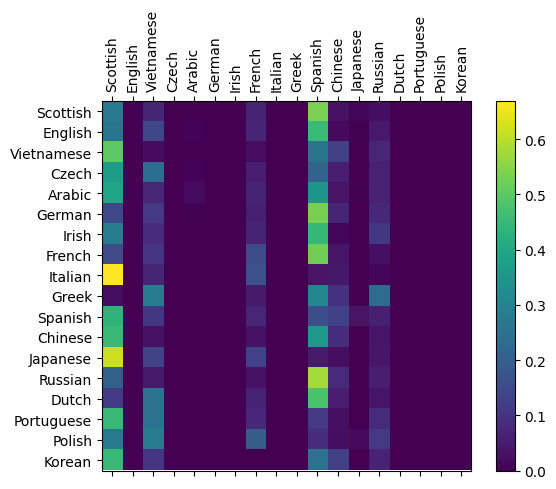

In [42]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Running on the user input

In [51]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict("Hazaki")
predict('Jackson')
predict('Dovesky')



> Hazaki
(-2.76) Vietnamese
(-2.77) French
(-2.79) Scottish

> Jackson
(-2.67) Spanish
(-2.72) Russian
(-2.79) Scottish

> Dovesky
(-2.77) Scottish
(-2.80) Vietnamese
(-2.82) Arabic
